In [1]:
!pip install pyarrow>=0.12.0 --upgrade
!pip install seaborn
!pip install tqdm
!pip install uuid

In [7]:
from azureml.core.authentication import InteractiveLoginAuthentication
from azureml.core import Experiment, Workspace, Dataset
from azureml.core.model import Model
from catboost import CatBoostClassifier, Pool, FeaturesData
from sklearn.model_selection import train_test_split, StratifiedKFold, ParameterGrid
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as  sns
import json
import joblib
from tqdm.notebook import tqdm
from uuid import uuid4
import warnings
from pandas.core.common import SettingWithCopyWarning
import pickle
SEED = 27
np.random.seed(SEED)
np.set_printoptions(precision=2)
sns.set(style='dark', font_scale=1.2, rc={'figure.figsize':(11, 7)})
pd.options.display.max_columns=1000
pd.options.display.precision=2
pd.options.display.float_format = '{:.2f}'.format
warnings.simplefilter(action='ignore', category=SettingWithCopyWarning)

In [8]:
interactive_auth = InteractiveLoginAuthentication(tenant_id="76f90eb1-fb9a-4446-9875-4d323d6455ad")
ws = Workspace.from_config(auth=interactive_auth)
print('Workspace name: ' + ws.name, sep='\n')

Workspace name: team27


In [3]:
aml_dataset = Dataset.get_by_name(ws, 'train_ds', version='latest')
df = aml_dataset.to_pandas_dataframe()

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 687029 entries, 0 to 687028
Columns: 196 entries, CardHolder to stdev_discount_depth_1m
dtypes: float64(191), int64(3), object(2)
memory usage: 1.0+ GB


In [5]:
df.head()

,CardHolder,age,cheque_count_12m_g20,cheque_count_12m_g21,cheque_count_12m_g25,cheque_count_12m_g32,cheque_count_12m_g33,cheque_count_12m_g38,cheque_count_12m_g39,cheque_count_12m_g41,cheque_count_12m_g42,cheque_count_12m_g45,cheque_count_12m_g46,cheque_count_12m_g48,cheque_count_12m_g52,cheque_count_12m_g56,cheque_count_12m_g57,cheque_count_12m_g58,cheque_count_12m_g79,cheque_count_3m_g20,cheque_count_3m_g21,cheque_count_3m_g25,cheque_count_3m_g42,cheque_count_3m_g45,cheque_count_3m_g52,cheque_count_3m_g56,cheque_count_3m_g57,cheque_count_3m_g79,cheque_count_6m_g20,cheque_count_6m_g21,cheque_count_6m_g25,cheque_count_6m_g32,cheque_count_6m_g33,cheque_count_6m_g38,cheque_count_6m_g39,cheque_count_6m_g40,cheque_count_6m_g41,cheque_count_6m_g42,cheque_count_6m_g45,cheque_count_6m_g46,cheque_count_6m_g48,cheque_count_6m_g52,cheque_count_6m_g56,cheque_count_6m_g57,cheque_count_6m_g58,cheque_count_6m_g79,children,crazy_purchases_cheque_count_12m,crazy_purchases_cheque_count_1m,crazy_purchases_cheque_count_3m,crazy_purchases_cheque_count_6m,crazy_purchases_goods_count_12m,crazy_purchases_goods_count_6m,disc_sum_6m_g34,food_share_15d,food_share_1m,gender,group,k_var_cheque_15d,k_var_cheque_3m,k_var_cheque_category_width_15d,k_var_cheque_group_width_15d,k_var_count_per_cheque_15d_g24,k_var_count_per_cheque_15d_g34,k_var_count_per_cheque_1m_g24,k_var_count_per_cheque_1m_g27,k_var_count_per_cheque_1m_g34,k_var_count_per_cheque_1m_g44,k_var_count_per_cheque_1m_g49,k_var_count_per_cheque_3m_g24,k_var_count_per_cheque_3m_g27,k_var_count_per_cheque_3m_g32,k_var_count_per_cheque_3m_g34,k_var_count_per_cheque_3m_g41,k_var_count_per_cheque_3m_g44,k_var_count_per_cheque_6m_g24,k_var_count_per_cheque_6m_g27,k_var_count_per_cheque_6m_g32,k_var_count_per_cheque_6m_g44,k_var_days_between_visits_15d,k_var_days_between_visits_1m,k_var_days_between_visits_3m,k_var_disc_per_cheque_15d,k_var_disc_share_12m_g32,k_var_disc_share_15d_g24,k_var_disc_share_15d_g34,k_var_disc_share_15d_g49,k_var_disc_share_1m_g24,k_var_disc_share_1m_g27,k_var_disc_share_1m_g34,k_var_disc_share_1m_g40,k_var_disc_share_1m_g44,k_var_disc_share_1m_g49,k_var_disc_share_1m_g54,k_var_disc_share_3m_g24,k_var_disc_share_3m_g26,k_var_disc_share_3m_g27,k_var_disc_share_3m_g32,k_var_disc_share_3m_g33,k_var_disc_share_3m_g34,k_var_disc_share_3m_g38,k_var_disc_share_3m_g40,k_var_disc_share_3m_g41,k_var_disc_share_3m_g44,k_var_disc_share_3m_g46,k_var_disc_share_3m_g48,k_var_disc_share_3m_g49,k_var_disc_share_3m_g54,k_var_disc_share_6m_g24,k_var_disc_share_6m_g27,k_var_disc_share_6m_g32,k_var_disc_share_6m_g34,k_var_disc_share_6m_g44,k_var_disc_share_6m_g46,k_var_disc_share_6m_g49,k_var_disc_share_6m_g54,k_var_discount_depth_15d,k_var_discount_depth_1m,k_var_sku_per_cheque_15d,k_var_sku_price_12m_g32,k_var_sku_price_15d_g34,k_var_sku_price_15d_g49,k_var_sku_price_1m_g24,k_var_sku_price_1m_g26,k_var_sku_price_1m_g27,k_var_sku_price_1m_g34,k_var_sku_price_1m_g40,k_var_sku_price_1m_g44,k_var_sku_price_1m_g49,k_var_sku_price_1m_g54,k_var_sku_price_3m_g24,k_var_sku_price_3m_g26,k_var_sku_price_3m_g27,k_var_sku_price_3m_g32,k_var_sku_price_3m_g33,k_var_sku_price_3m_g34,k_var_sku_price_3m_g40,k_var_sku_price_3m_g41,k_var_sku_price_3m_g44,k_var_sku_price_3m_g46,k_var_sku_price_3m_g48,k_var_sku_price_3m_g49,k_var_sku_price_3m_g54,k_var_sku_price_6m_g24,k_var_sku_price_6m_g26,k_var_sku_price_6m_g27,k_var_sku_price_6m_g32,k_var_sku_price_6m_g41,k_var_sku_price_6m_g42,k_var_sku_price_6m_g44,k_var_sku_price_6m_g48,k_var_sku_price_6m_g49,main_format,mean_discount_depth_15d,months_from_register,perdelta_days_between_visits_15_30d,promo_share_15d,response_att,response_sms,response_viber,sale_count_12m_g32,sale_count_12m_g33,sale_count_12m_g49,sale_count_12m_g54,sale_count_12m_g57,sale_count_3m_g24,sale_count_3m_g33,sale_count_3m_g57,sale_count_6m_g24,sale_count_6m_g25,sale_count_6m_g32,sale_count_6m_g33,sale_count_6m_g44,sale_count_6m_g54,sale_count_6m_g57,sale_sum_12m_g24,sale_sum_12m_g25,sale_sum_12m_g26,

In [6]:
df.describe()

,CardHolder,age,cheque_count_12m_g20,cheque_count_12m_g21,cheque_count_12m_g25,cheque_count_12m_g32,cheque_count_12m_g33,cheque_count_12m_g38,cheque_count_12m_g39,cheque_count_12m_g41,cheque_count_12m_g42,cheque_count_12m_g45,cheque_count_12m_g46,cheque_count_12m_g48,cheque_count_12m_g52,cheque_count_12m_g56,cheque_count_12m_g57,cheque_count_12m_g58,cheque_count_12m_g79,cheque_count_3m_g20,cheque_count_3m_g21,cheque_count_3m_g25,cheque_count_3m_g42,cheque_count_3m_g45,cheque_count_3m_g52,cheque_count_3m_g56,cheque_count_3m_g57,cheque_count_3m_g79,cheque_count_6m_g20,cheque_count_6m_g21,cheque_count_6m_g25,cheque_count_6m_g32,cheque_count_6m_g33,cheque_count_6m_g38,cheque_count_6m_g39,cheque_count_6m_g40,cheque_count_6m_g41,cheque_count_6m_g42,cheque_count_6m_g45,cheque_count_6m_g46,cheque_count_6m_g48,cheque_count_6m_g52,cheque_count_6m_g56,cheque_count_6m_g57,cheque_count_6m_g58,cheque_count_6m_g79,children,crazy_purchases_cheque_count_12m,crazy_purchases_cheque_count_1m,crazy_purchases_cheque_count_3m,crazy_purchases_cheque_count_6m,crazy_purchases_goods_count_12m,crazy_purchases_goods_count_6m,disc_sum_6m_g34,food_share_15d,food_share_1m,k_var_cheque_15d,k_var_cheque_3m,k_var_cheque_category_width_15d,k_var_cheque_group_width_15d,k_var_count_per_cheque_15d_g24,k_var_count_per_cheque_15d_g34,k_var_count_per_cheque_1m_g24,k_var_count_per_cheque_1m_g27,k_var_count_per_cheque_1m_g34,k_var_count_per_cheque_1m_g44,k_var_count_per_cheque_1m_g49,k_var_count_per_cheque_3m_g24,k_var_count_per_cheque_3m_g27,k_var_count_per_cheque_3m_g32,k_var_count_per_cheque_3m_g34,k_var_count_per_cheque_3m_g41,k_var_count_per_cheque_3m_g44,k_var_count_per_cheque_6m_g24,k_var_count_per_cheque_6m_g27,k_var_count_per_cheque_6m_g32,k_var_count_per_cheque_6m_g44,k_var_days_between_visits_15d,k_var_days_between_visits_1m,k_var_days_between_visits_3m,k_var_disc_per_cheque_15d,k_var_disc_share_12m_g32,k_var_disc_share_15d_g24,k_var_disc_share_15d_g34,k_var_disc_share_15d_g49,k_var_disc_share_1m_g24,k_var_disc_share_1m_g27,k_var_disc_share_1m_g34,k_var_disc_share_1m_g40,k_var_disc_share_1m_g44,k_var_disc_share_1m_g49,k_var_disc_share_1m_g54,k_var_disc_share_3m_g24,k_var_disc_share_3m_g26,k_var_disc_share_3m_g27,k_var_disc_share_3m_g32,k_var_disc_share_3m_g33,k_var_disc_share_3m_g34,k_var_disc_share_3m_g38,k_var_disc_share_3m_g40,k_var_disc_share_3m_g41,k_var_disc_share_3m_g44,k_var_disc_share_3m_g46,k_var_disc_share_3m_g48,k_var_disc_share_3m_g49,k_var_disc_share_3m_g54,k_var_disc_share_6m_g24,k_var_disc_share_6m_g27,k_var_disc_share_6m_g32,k_var_disc_share_6m_g34,k_var_disc_share_6m_g44,k_var_disc_share_6m_g46,k_var_disc_share_6m_g49,k_var_disc_share_6m_g54,k_var_discount_depth_15d,k_var_discount_depth_1m,k_var_sku_per_cheque_15d,k_var_sku_price_12m_g32,k_var_sku_price_15d_g34,k_var_sku_price_15d_g49,k_var_sku_price_1m_g24,k_var_sku_price_1m_g26,k_var_sku_price_1m_g27,k_var_sku_price_1m_g34,k_var_sku_price_1m_g40,k_var_sku_price_1m_g44,k_var_sku_price_1m_g49,k_var_sku_price_1m_g54,k_var_sku_price_3m_g24,k_var_sku_price_3m_g26,k_var_sku_price_3m_g27,k_var_sku_price_3m_g32,k_var_sku_price_3m_g33,k_var_sku_price_3m_g34,k_var_sku_price_3m_g40,k_var_sku_price_3m_g41,k_var_sku_price_3m_g44,k_var_sku_price_3m_g46,k_var_sku_price_3m_g48,k_var_sku_price_3m_g49,k_var_sku_price_3m_g54,k_var_sku_price_6m_g24,k_var_sku_price_6m_g26,k_var_sku_price_6m_g27,k_var_sku_price_6m_g32,k_var_sku_price_6m_g41,k_var_sku_price_6m_g42,k_var_sku_price_6m_g44,k_var_sku_price_6m_g48,k_var_sku_price_6m_g49,main_format,mean_discount_depth_15d,months_from_register,perdelta_days_between_visits_15_30d,promo_share_15d,response_att,response_sms,response_viber,sale_count_12m_g32,sale_count_12m_g33,sale_count_12m_g49,sale_count_12m_g54,sale_count_12m_g57,sale_count_3m_g24,sale_count_3m_g33,sale_count_3m_g57,sale_count_6m_g24,sale_count_6m_g25,sale_count_6m_g32,sale_count_6m_g33,sale_count_6m_g44,sale_count_6m_g54,sale_count_6m_g57,sale_sum_12m_g24,sale_sum_12m_g25,sale_sum_12m_g26,sale_sum_12m_

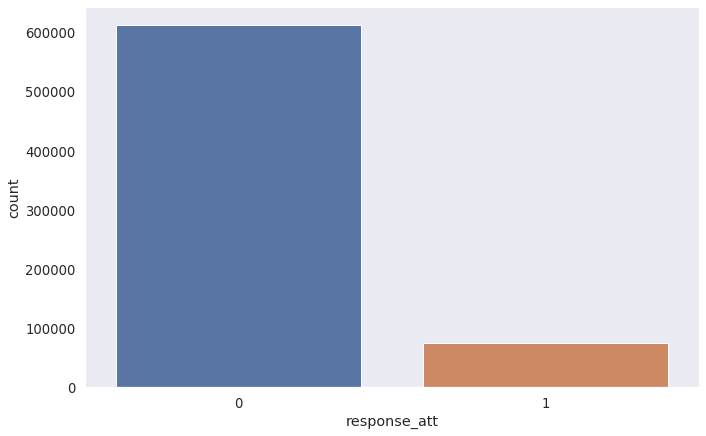

In [7]:
sns.countplot(df['response_att']);

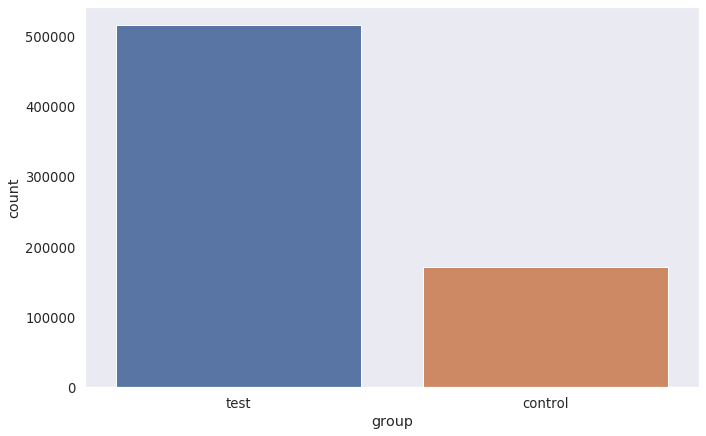

In [8]:
sns.countplot(df['group']);

In [9]:
df = df.query('gender == ["Ж", "М"]')

In [10]:
X = df.drop('response_att', axis=1)
y = df['response_att']

In [11]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=True, random_state=SEED)

In [12]:
def make_features(X, fill_na=False):
    X['children_many'] = X['children'].map(lambda x: 0 if x == 0 else (1 if x < 4 else 2))
    X['response_high'] = X['response_sms'] * X['response_viber']
    X['old'] = X['age'].map(lambda x: 0 if x < 25 else (1 if x < 50 else 2))
    X['mother'] = np.logical_and(X['gender'] == 'Ж', X['children'] > 0).apply(int)
    X['dad'] = np.logical_and(X['gender'] == 'М', X['children'] > 0).apply(int)
    X['mother_young'] = np.logical_and(X['mother'] == 1, X['old'] == 0).apply(int)
    X['dad_young'] = np.logical_and(X['dad'] == 1, X['old'] == 0).apply(int)
    
    sale_sum_3m = [col for col in X if col.startswith('sale_sum_3m')]
    sale_sum_6m = [col for col in X if col.startswith('sale_sum_6m')]
    sale_sum_12m = [col for col in X if col.startswith('sale_sum_12m')]
    sale_count_3m = [col for col in X if col.startswith('sale_count_3m')]
    sale_count_6m = [col for col in X if col.startswith('sale_count_6m')]
    sale_count_12m = [col for col in X if col.startswith('sale_count_12m')]
    k_var_sku_price_1m = [col for col in X if col.startswith('k_var_sku_price_1m')]
    k_var_sku_price_3m = [col for col in X if col.startswith('k_var_sku_price_3m')]
    k_var_sku_price_6m = [col for col in X if col.startswith('k_var_sku_price_6m')]
    k_var_disc_share_1m = [col for col in X if col.startswith('k_var_disc_share_1m')]
    k_var_disc_share_3m = [col for col in X if col.startswith('k_var_disc_share_3m')]
    k_var_disc_share_6m = [col for col in X if col.startswith('k_var_disc_share_6m')]
    k_var_count_per_cheque_1m = [col for col in X if col.startswith('k_var_count_per_cheque_1m')]
    k_var_count_per_cheque_3m = [col for col in X if col.startswith('k_var_count_per_cheque_3m')]
    k_var_count_per_cheque_6m = [col for col in X if col.startswith('k_var_count_per_cheque_6m')]
    cheque_count_3m = [col for col in X if col.startswith('cheque_count_3m')]
    cheque_count_6m = [col for col in X if col.startswith('cheque_count_6m')]
    cheque_count_12m = [col for col in X if col.startswith('cheque_count_12m')]
    crazy_purchases_cheque_count = [col for col in X if col.startswith('crazy_purchases_cheque_count')]
    
    X['crazy_purchases_goods'] = X['crazy_purchases_goods_count_6m'] / X['crazy_purchases_goods_count_12m']
    
    X['sale_sum_3m_sum'] = X[sale_sum_3m].sum(axis=1)
    X['sale_sum_3m_mean'] = X[sale_sum_3m].mean(axis=1)
    X['sale_sum_3m_std'] = X[sale_sum_3m].std(axis=1)
    
    X['sale_sum_6m_sum'] = X[sale_sum_6m].sum(axis=1)
    X['sale_sum_6m_mean'] = X[sale_sum_6m].mean(axis=1)
    X['sale_sum_6m_std'] = X[sale_sum_6m].std(axis=1)
    
    X['sale_sum_12m_sum'] = X[sale_sum_12m].sum(axis=1)
    X['sale_sum_12m_mean'] = X[sale_sum_12m].mean(axis=1)
    X['sale_sum_12m_std'] = X[sale_sum_12m].std(axis=1)
    
    X['sale_count_3m_sum'] = X[sale_count_3m].sum(axis=1)
    X['sale_count_3m_mean'] = X[sale_count_3m].mean(axis=1)
    X['sale_count_3m_std'] = X[sale_count_3m].std(axis=1)
    
    X['sale_count_6m_sum'] = X[sale_count_6m].sum(axis=1)
    X['sale_count_6m_mean'] = X[sale_count_6m].mean(axis=1)
    X['sale_count_6m_std'] = X[sale_count_6m].std(axis=1)
    
    X['sale_count_12m_sum'] = X[sale_count_12m].sum(axis=1)
    X['sale_count_12m_mean'] = X[sale_count_12m].mean(axis=1)
    X['sale_count_12m_std'] = X[sale_count_12m].std(axis=1)
    
    X['k_var_sku_price_1m_sum'] = X[k_var_sku_price_1m].sum(axis=1)
    X['k_var_sku_price_1m_mean'] = X[k_var_sku_price_1m].mean(axis=1)
    X['k_var_sku_price_1m_std'] = X[k_var_sku_price_1m].std(axis=1)
    
    X['k_var_sku_price_3m_sum'] = X[k_var_sku_price_3m].sum(axis=1)
    X['k_var_sku_price_3m_mean'] = X[k_var_sku_price_3m].mean(axis=1)
    X['k_var_sku_price_3m_std'] = X[k_var_sku_price_3m].std(axis=1)
    
    X['k_var_sku_price_6m_sum'] = X[k_var_sku_price_6m].sum(axis=1)
    X['k_var_sku_price_6m_mean'] = X[k_var_sku_price_6m].mean(axis=1)
    X['k_var_sku_price_6m_std'] = X[k_var_sku_price_6m].std(axis=1)
    
    X['k_var_disc_share_1m_sum'] = X[k_var_disc_share_1m].sum(axis=1)
    X['k_var_disc_share_1m_mean'] = X[k_var_disc_share_1m].mean(axis=1)
    X['k_var_disc_share_1m_std'] = X[k_var_disc_share_1m].std(axis=1)
    
    X['k_var_disc_share_3m_sum'] = X[k_var_disc_share_3m].sum(axis=1)
    X['k_var_disc_share_3m_mean'] = X[k_var_disc_share_3m].mean(axis=1)
    X['k_var_disc_share_3m_std'] = X[k_var_disc_share_3m].std(axis=1)
    
    X['k_var_disc_share_6m_sum'] = X[k_var_disc_share_6m].sum(axis=1)
    X['k_var_disc_share_6m_mean'] = X[k_var_disc_share_6m].mean(axis=1)
    X['k_var_disc_share_6m_std'] = X[k_var_disc_share_6m].std(axis=1)
    
    X['k_var_count_per_cheque_1m_sum'] = X[k_var_count_per_cheque_1m].sum(axis=1)
    X['k_var_count_per_cheque_1m_mean'] = X[k_var_count_per_cheque_1m].mean(axis=1)
    X['k_var_count_per_cheque_1m_std'] = X[k_var_count_per_cheque_1m].std(axis=1)
    
    X['k_var_count_per_cheque_3m_sum'] = X[k_var_count_per_cheque_3m].sum(axis=1)
    X['k_var_count_per_cheque_3m_mean'] = X[k_var_count_per_cheque_3m].mean(axis=1)
    X['k_var_count_per_cheque_3m_std'] = X[k_var_count_per_cheque_3m].std(axis=1)
    
    X['k_var_count_per_cheque_6m_sum'] = X[k_var_count_per_cheque_6m].sum(axis=1)
    X['k_var_count_per_cheque_6m_mean'] = X[k_var_count_per_cheque_6m].mean(axis=1)
    X['k_var_count_per_cheque_6m_std'] = X[k_var_count_per_cheque_6m].std(axis=1)
    
    X['cheque_count_3m_sum'] = X[cheque_count_3m].sum(axis=1)
    X['cheque_count_3m_mean'] = X[cheque_count_3m].mean(axis=1)
    X['cheque_count_3m_std'] = X[cheque_count_3m].std(axis=1)
    
    X['cheque_count_6m_sum'] = X[cheque_count_6m].sum(axis=1)
    X['cheque_count_6m_mean'] = X[cheque_count_6m].mean(axis=1)
    X['cheque_count_6m_std'] = X[cheque_count_6m].std(axis=1)
    
    X['cheque_count_12m_sum'] = X[cheque_count_12m].sum(axis=1)
    X['cheque_count_12m_mean'] = X[cheque_count_12m].mean(axis=1)
    X['cheque_count_12m_std'] = X[cheque_count_12m].std(axis=1)
    
    X['crazy_purchases_cheque_count_sum'] = X[crazy_purchases_cheque_count].sum(axis=1)
    X['crazy_purchases_cheque_count_mean'] = X[crazy_purchases_cheque_count].mean(axis=1)
    X['crazy_purchases_cheque_count_std'] = X[crazy_purchases_cheque_count].std(axis=1)
    
    if fill_na:
        cat_features = [
            'gender', 'group', 'main_format', 'CardHolder', 'children_many', 'old', 'mother', 'dad', 'mother_young', 'dad_young'
        ]
        num_features = [col for col in X if col not in cat_features and col != 'response_att']
        fillna_dict = {col: 'other' if col in cat_features else -1 for col in X}
        X.fillna(fillna_dict, inplace=True)

In [ ]:
make_features(X_train, fill_na=True)
make_features(X_test, fill_na=True)

In [15]:
def skf_cv_score(X, y, num_features, cat_features, n_splits=3, random_seed=None, shuffle=False, tqdm_leave=True, **params):
    
    X = X.reset_index(drop=True)
    y = y.reset_index(drop=True)
    
    CLF_DEFAULT_PARAMS = {
        'logging_level': 'Silent'
    }
    clf = CatBoostClassifier(**CLF_DEFAULT_PARAMS, **params)
    
    scores = np.zeros((1, n_splits))
    trees = np.zeros((1, n_splits))
    
    skf = StratifiedKFold(n_splits=n_splits, random_state=random_seed, shuffle=shuffle) 
    for n_split, (train_ind, test_ind) in enumerate(tqdm(skf.split(X, y), 
                                                         desc='CV', 
                                                         total=n_splits, 
                                                         leave=tqdm_leave)
                                                   ):
        Xy_train = Pool(
            data=FeaturesData(
                num_feature_data=X.loc[train_ind, num_features].to_numpy(dtype=np.float32),
                cat_feature_data=X.loc[train_ind, cat_features].to_numpy(dtype=str).astype(object),
                num_feature_names=num_features,
                cat_feature_names=cat_features
            ),
            label=y.iloc[train_ind].to_numpy(dtype=str).astype(object)
        )
        
        Xy_test = Pool(
            data=FeaturesData(
                num_feature_data=X.loc[test_ind, num_features].to_numpy(dtype=np.float32),
                cat_feature_data=X.loc[test_ind, cat_features].to_numpy(dtype=str).astype(object),
                num_feature_names=num_features,
                cat_feature_names=cat_features
            ),
            label=y.iloc[test_ind].to_numpy(dtype=str).astype(object)
        )
        
        clf.fit(Xy_train, eval_set=Xy_test, early_stopping_rounds=100)
        trees[0, n_split] = clf.tree_count_
        scores[0, n_split] = clf.best_score_['validation']['Logloss']
    
    return scores, trees


def grid_search_skf_cv_score(X, y, num_features, cat_features, params_grid, n_splits=3,
                             random_seed=None, shuffle=False, tqdm_leave=True, azure_logging=False):
    if azure_logging:
        experiment = Experiment(workspace=ws, name='grid_search_' + str(uuid4()))
        run = experiment.start_logging(snapshot_directory=None)
    
    best_result = np.inf
    for params in tqdm(ParameterGrid(params_grid), desc='GridSearch', leave=tqdm_leave):
        cv_scores, cv_trees = skf_cv_score(X=X, y=y, num_features=num_features, cat_features=cat_features, n_splits=n_splits, 
                                           **params, random_seed=random_seed, shuffle=shuffle, tqdm_leave=False)
        cv_score = cv_scores.mean()
        cv_tree = int(cv_trees.mean())
        params['iterations'] = cv_tree
        
        if azure_logging:
            run.log(json.dumps(params), cv_score)
        if cv_score < best_result:
            best_params = params
            best_result = cv_score
            
    return {'best_params': best_params, 'best_result': best_result}

In [16]:
cat_features = [
    'gender', 'group', 'main_format', 'CardHolder', 'children_many', 'old', 'mother', 'dad', 'mother_young', 'dad_young'
]
num_features = [col for col in df if col not in cat_features and col != 'response_att']

In [17]:
X_train_w0 = X_train.query('group == "control"')
y_train_w0 = y_train[X_train_w0.index]

X_train_w1 = X_train.query('group == "test"')
y_train_w1 = y_train[X_train_w1.index]

In [18]:
params_grid = {
    'learning_rate': [0.03],
    'depth': [6, 7, 8],
    'max_ctr_complexity': [1, 2]
}

In [19]:
w0_best_params = grid_search_skf_cv_score(X_train_w0, y_train_w0, num_features=num_features, cat_features=cat_features,
                                          params_grid=params_grid, azure_logging=True, n_splits=4,
                                          shuffle=True, random_seed=SEED)['best_params']

In [20]:
m_w0 = CatBoostClassifier(**w0_best_params.update({'iterations':1000}))

Xy_train_w0 = Pool(
    data=X_train_w0,
    label=y_train_w0,
    cat_features=cat_features
)

In [21]:
m_w0.fit(Xy_train_w0, verbose=100)

0:	learn: 0.6608309	total: 57.1ms	remaining: 38.7s
100:	learn: 0.2709701	total: 4.11s	remaining: 23.5s
200:	learn: 0.2664782	total: 8.13s	remaining: 19.3s
300:	learn: 0.2640188	total: 12.2s	remaining: 15.3s
400:	learn: 0.2616904	total: 16.2s	remaining: 11.2s
500:	learn: 0.2589253	total: 20.3s	remaining: 7.2s
600:	learn: 0.2562918	total: 24.2s	remaining: 3.14s
678:	learn: 0.2542613	total: 27.3s	remaining: 0us


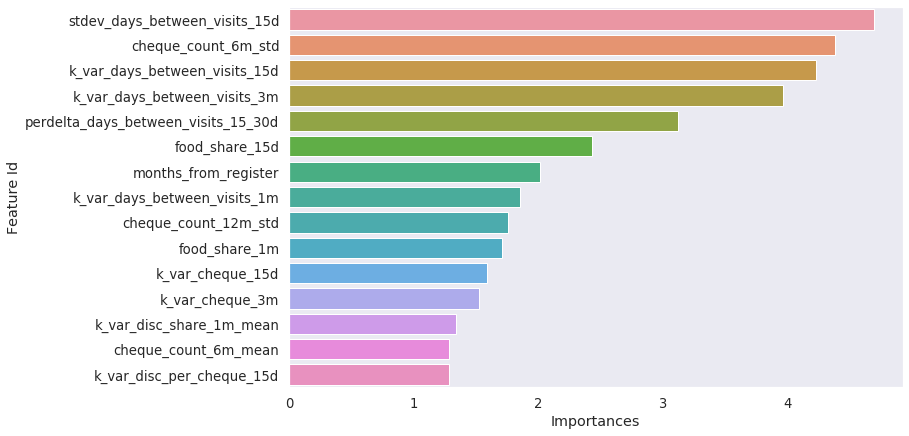

In [22]:
m_w0_feature_importance = m_w0.get_feature_importance(prettified=True)
sns.barplot(y='Feature Id', x='Importances', data=m_w0_feature_importance.head(15));

In [23]:
joblib.dump(value=m_w0, filename='outputs/m_w0.pkl')

['outputs/m_w0.pkl']

In [24]:
m_w0_ws = Model.register(
    model_path='outputs/m_w0.pkl',
    model_name='m_w0',
    description='Model on control',
    workspace=ws
)

Registering model m_w0


In [25]:
w1_best_params = grid_search_skf_cv_score(X_train_w1, y_train_w1, num_features=num_features, cat_features=cat_features,
                                          params_grid=params_grid, azure_logging=True, 
                                          shuffle=True, random_seed=SEED)['best_params']

In [26]:
m_w1 = CatBoostClassifier(**w1_best_params)

Xy_train_w1 = Pool(
    data=X_train_w1,
    label=y_train_w1,
    cat_features=cat_features
)

m_w1.fit(Xy_train_w1, verbose=100)

0:	learn: 0.6624960	total: 149ms	remaining: 2m 3s
100:	learn: 0.2857469	total: 10.1s	remaining: 1m 12s
200:	learn: 0.2817457	total: 20s	remaining: 1m 2s
300:	learn: 0.2794534	total: 29.7s	remaining: 52.3s
400:	learn: 0.2774173	total: 39.4s	remaining: 42.3s
500:	learn: 0.2752564	total: 49s	remaining: 32.3s
600:	learn: 0.2729935	total: 58.9s	remaining: 22.6s
700:	learn: 0.2708021	total: 1m 8s	remaining: 12.7s
800:	learn: 0.2686230	total: 1m 18s	remaining: 2.93s
830:	learn: 0.2679717	total: 1m 21s	remaining: 0us


In [27]:
joblib.dump(value=m_w0, filename='outputs/m_w1.pkl')

['outputs/m_w1.pkl']

In [28]:
m_w1_ws = Model.register(
    model_path='outputs/m_w1.pkl',
    model_name='m_w1',
    description='Model on test',
    workspace=ws
)

Registering model m_w1


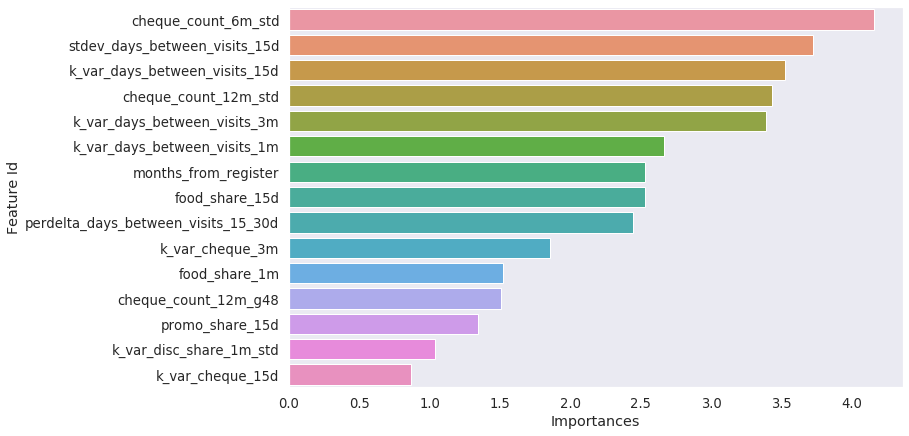

In [29]:
m_w1_feature_importance = m_w1.get_feature_importance(prettified=True)
sns.barplot(y='Feature Id', x='Importances', data=m_w1_feature_importance.head(15));

In [18]:
def uplift_two_models(m_w1, m_w0, X):
    return m_w1.predict_proba(X)[:, 1] - m_w0.predict_proba(X)[:, 1]

In [16]:
def custom_metric(answers, take_top_ratio=0.25):
    answers.sort_values(by='uplift', inplace=True, ascending=False)
    n_samples = int(np.ceil(answers.shape[0] * take_top_ratio))
    answers = answers.iloc[:n_samples, :]
    answers_test = answers[answers['group'] == 'test']['response_att'].sum() / \
                   answers[answers['group'] == 'test'].shape[0]
    answers_control = answers[answers['group'] == 'control']['response_att'].sum() / \
                      answers[answers['group'] == 'control'].shape[0]
    return (answers_test - answers_control) * 100